# Canada Tax Revenue

Data from [here](https://www150.statcan.gc.ca/t1/tbl1/en/cv!recreate.action?pid=1010001701&selectedNodeIds=1D1,1D2,1D3,1D4,1D5,1D6,1D7,1D9,1D8,1D10,1D11,1D12,1D13,2D1,3D1,3D2,4D1,4D2,4D5,4D9,4D10,4D11,4D26,4D36,4D45,4D48,4D49,4D50,4D4,4D27,4D32,4D35,4D52,4D53,4D54,4D55,4D56,4D62,4D65,4D72,4D3All,4D3,4D51,4D130,4D81,4D82,4D85,4D86,4D90,4D91,4D95,4D98,4D102,4D103,4D106,4D108,4D109,4D114,4D118,4D119,4D122,4D125,4D89,4D107,4D87All,4D87,4D88,4D126,4D127,4D128,4D129,4D83All,4D83,4D84,&checkedLevels=3D1,3D2,3D3,3D4,3D5,3D6,&refPeriods=20070101,20170101&dimensionLayouts=layout3,layout3,layout3,layout3,layout2&vectorDisplay=true)

I also put the data [here on data.world](https://data.world/cottrell/canada/) but haven't done anything with it.

Skip to [the charts](#Charts)

# Data Prep

In [2]:
import pandas as pd
import seaborn as sns
from pylab import *

In [3]:
def drop_noninteresting_and_normalized_colnames(df):
    df.columns = [x.lower().replace(' ', '_') for x in df.columns]
    todrop = list()
    for k in df:
        if df[k].nunique() == 1:
            print('dropping {}'.format(k))
            todrop.append(k)
    return df.drop(todrop, axis=1)

In [51]:
df_orig = drop_noninteresting_and_normalized_colnames(pd.read_csv('10100017.csv'))
p_orig = drop_noninteresting_and_normalized_colnames(pd.read_csv('17100005.csv'))

df = df_orig.rename(columns={
    'statement_of_operations_and_balance_sheet': 'entry',
    'display_value': 'value_type'})
df = df[df.value_type == 'Stocks']


df = df[df.ref_date != 2007]

p = p_orig[~p_orig.age_group.str.contains(' to ')]
p = p[~p_orig.age_group.str.contains(' and over')]
p = p[~p_orig.age_group.str.contains('All')]
p = p[~p_orig.age_group.str.contains('Median')]
p = p[p.sex != 'Both sexes']
p['age_group'] = p.age_group.apply(lambda x: int(x.split(' ')[0]))

p = p.set_index(['ref_date', 'geo', 'sex', 'age_group'])['value'].unstack(['sex', 'age_group']).sort_index(axis=1)

p = p.fillna(0)

dropping public_sector_components
dropping uom
dropping uom_id
dropping scalar_factor
dropping scalar_id
dropping status
dropping decimals


/home/cottrell/anaconda3/envs/36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


dropping scalar_factor
dropping scalar_id
dropping status
dropping terminated


/home/cottrell/anaconda3/envs/36/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/cottrell/anaconda3/envs/36/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cottrell/anaconda3/envs/36/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


In [91]:
s = df.set_index(['ref_date', 'geo', 'entry']).value.dropna()
assert s.index.is_unique
d = s.unstack(['entry']).fillna(0)

In [94]:
d.head().T.head().T

entry                               Gross operating balance  Net operating balance  Revenue    Taxes  Taxes on income, profits and capital gains
ref_date geo                                                                                                                                    
2008     Alberta                                     4696.0                 3555.0  43000.0  20509.0                                     13799.0
         British Columbia                            -324.0                -1533.0  36396.0  23328.0                                     10406.0
         Manitoba                                     443.0                  120.0  12103.0   6483.0                                      2884.0
         New Brunswick                                -44.0                 -558.0   7456.0   3705.0                                      1484.0
         Newfoundland and Labrador                   1054.0                  865.0   7274.0   2738.0                                      1276.0

In [96]:
dd = (d - d.mean()) / d.std()

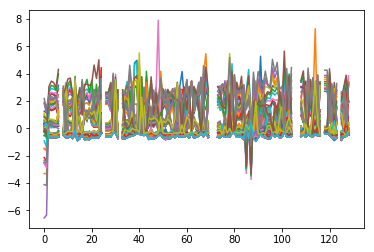

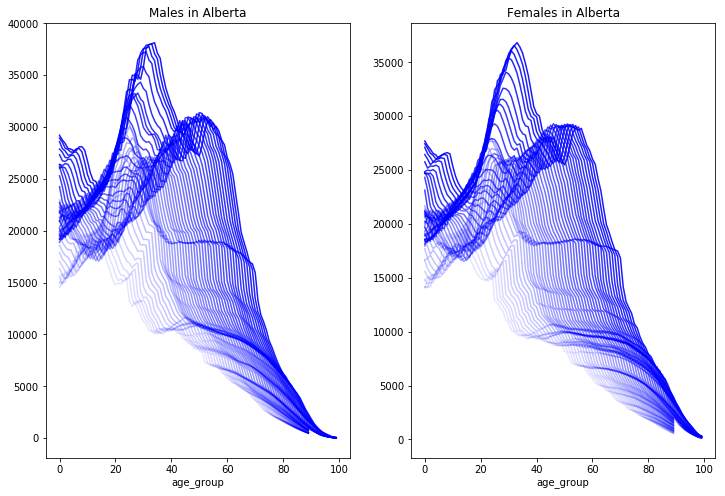

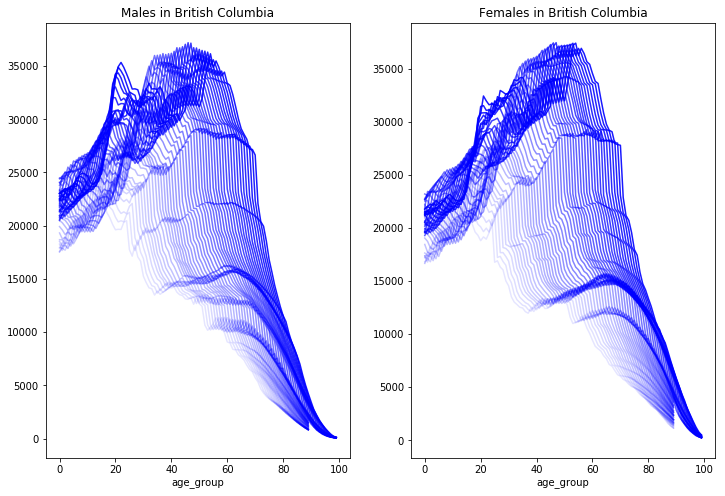

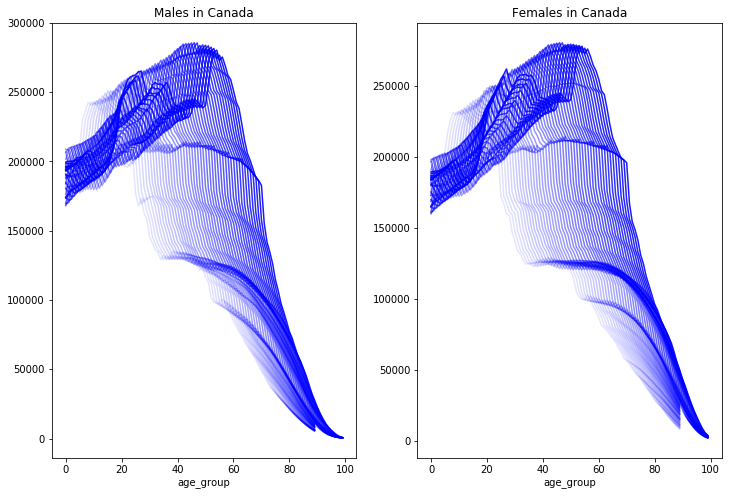

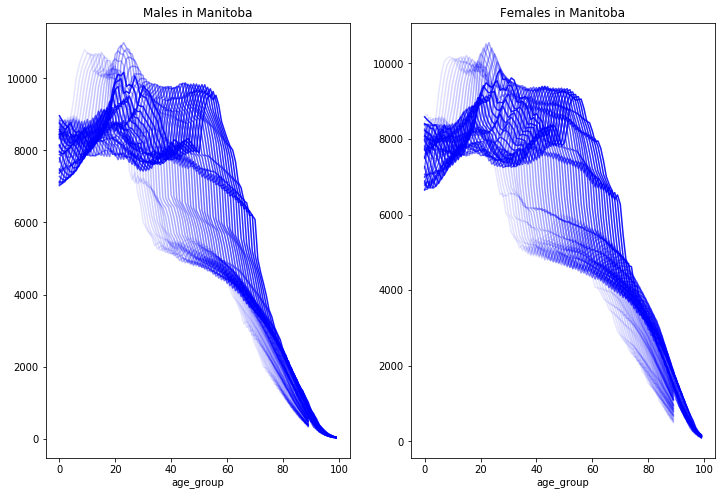

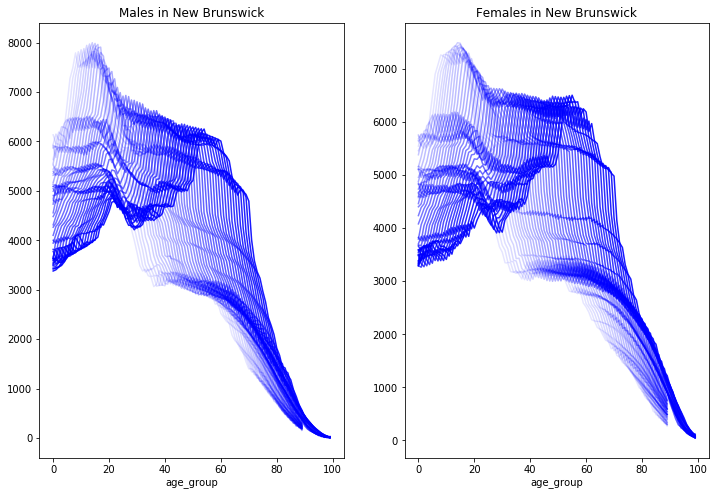

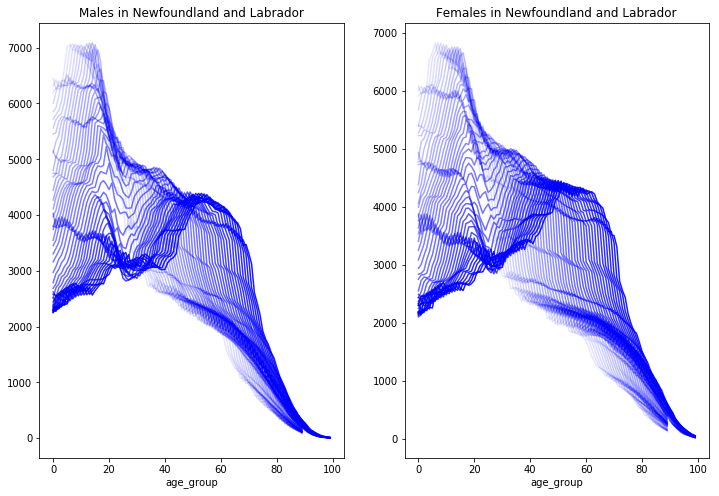

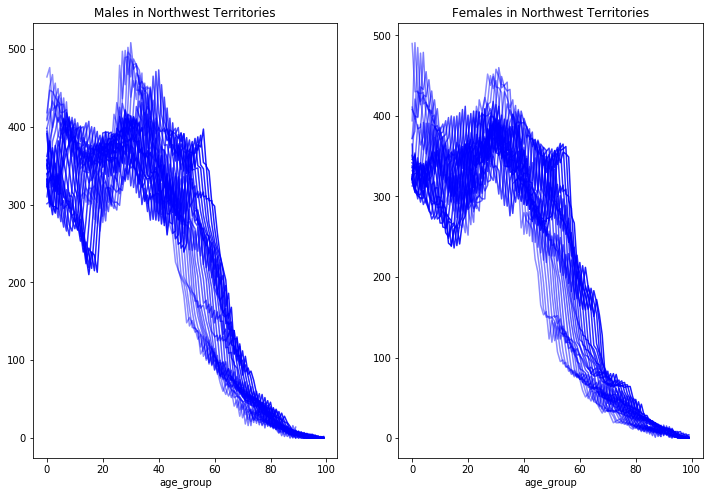

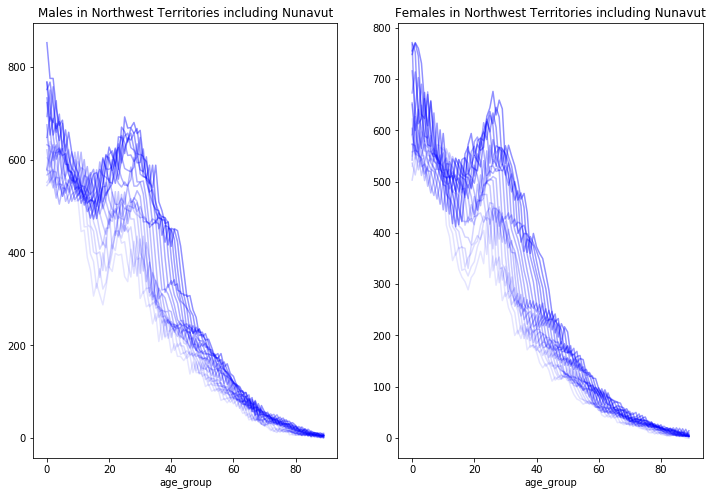

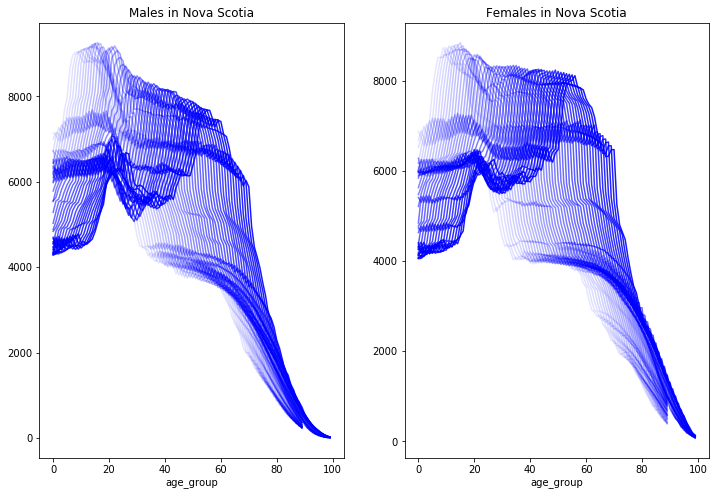

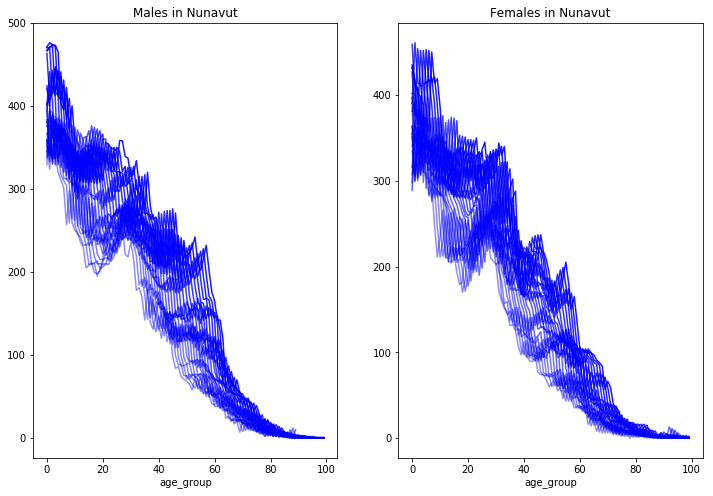

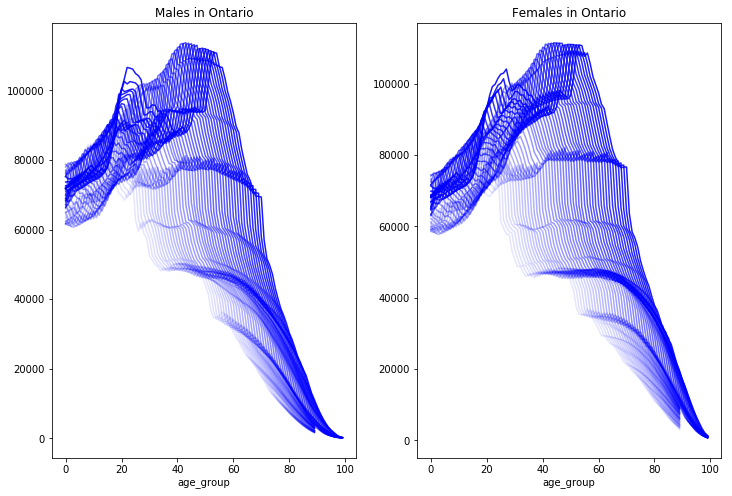

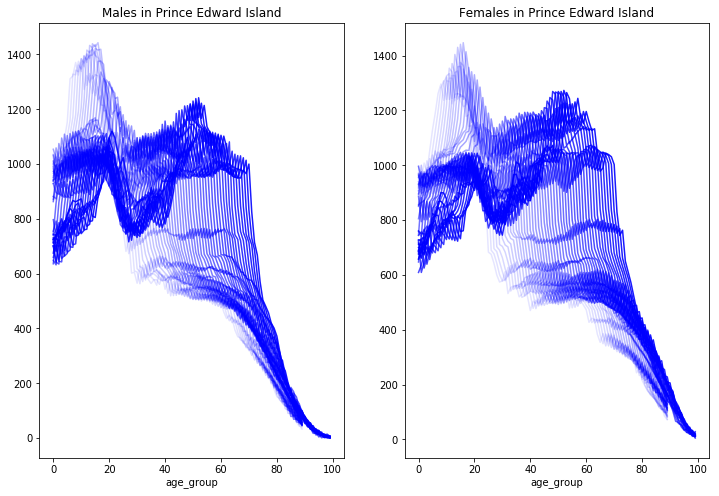

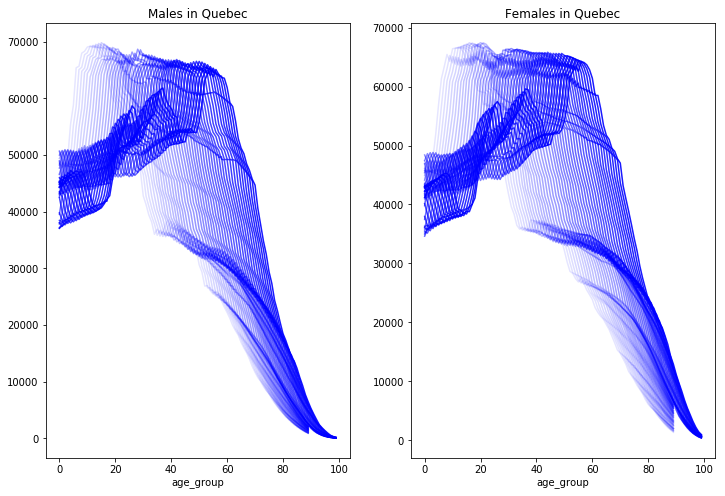

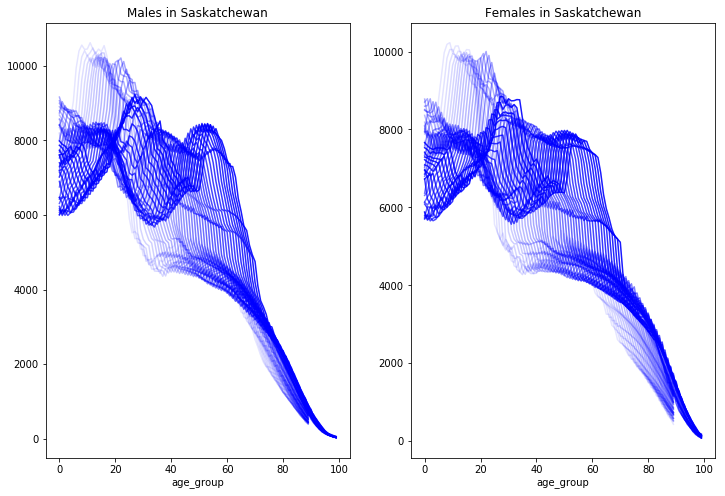

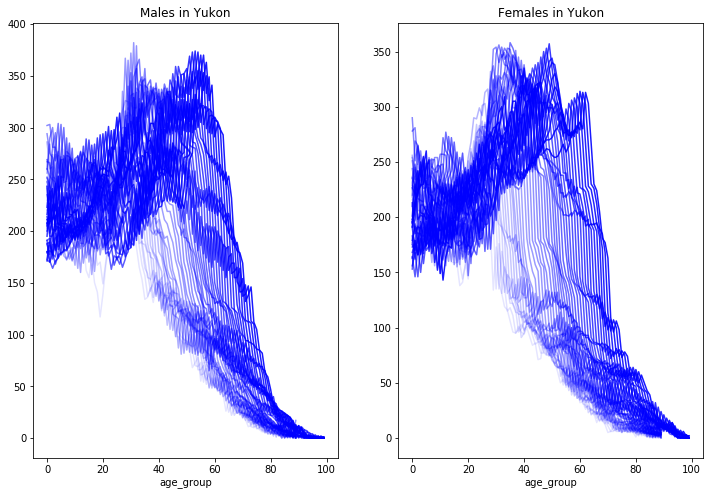

In [10]:
for k, v in p.groupby(level='geo', group_keys=False):
    figure(figsize=(12, 8))
    v.index = v.index.droplevel('geo')
    for i, kk in enumerate(['Males', 'Females']):
        ax = subplot(1, 2, i+1)
        vv = v[kk].T
#         vv = vv / vv.iloc[0] - 1 + np.arange(vv.shape[1]) * 0.1
        for kkk in vv.columns:
            alpha = (kkk - 1971) / (2017 - 1971) 
            alpha = 0.1 + (1 - 0.1 * 2) * alpha
            vv[kkk].plot(ax=ax, alpha=alpha, color='b', legend=False)
            title('{} in {}'.format(kk, k))
#             legend()
#     break

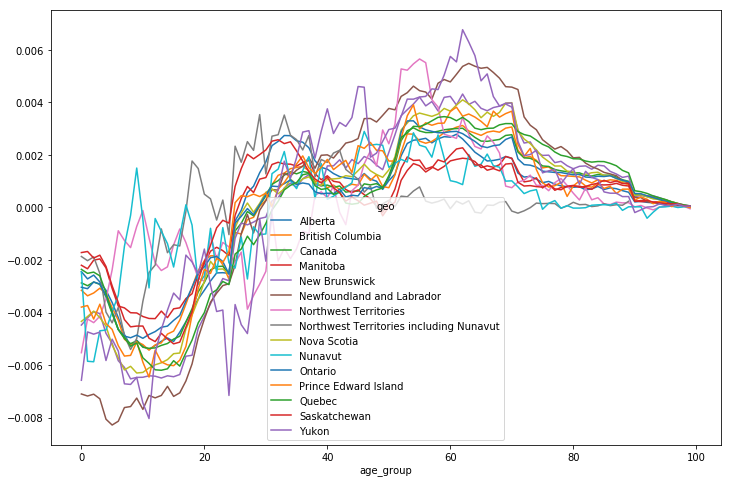

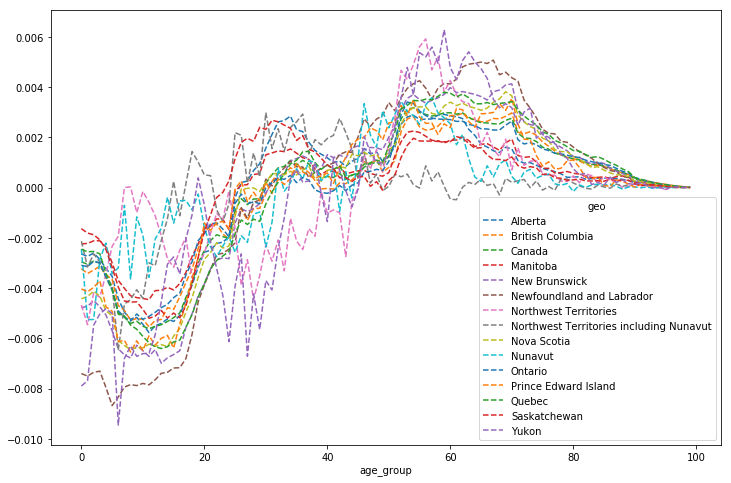

In [36]:
pp = (p.T / p.T.sum()).T
g = pp.sort_index().groupby(level='geo')
ch = g.last() - g.first()
ch = ch.T

figure(figsize=(12, 8))
ax = gca()
ch.loc['Females'].plot(ax=ax, style='-')
figure(figsize=(12, 8))
ax = gca()
ch.loc['Males'].plot(ax=ax, style='--')

In [53]:
s = df.set_index(['ref_date', 'geo', 'entry']).value.dropna()
assert s.index.is_unique
d = s.unstack(['entry']).fillna(0)

# HERE HAX and NORMS
d = (d.T / d.Revenue).T
p = (p.T / p.T.sum()).T

dd = d.join(p, how='left')
d.shape, p.shape, dd.shape

/home/cottrell/anaconda3/envs/36/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


((130, 129), (638, 200), (130, 329))

In [54]:
import sklearn.preprocessing as sp

In [55]:
import umap

/home/cottrell/anaconda3/envs/36/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components
/home/cottrell/anaconda3/envs/36/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


Text(0.5,1,'both')

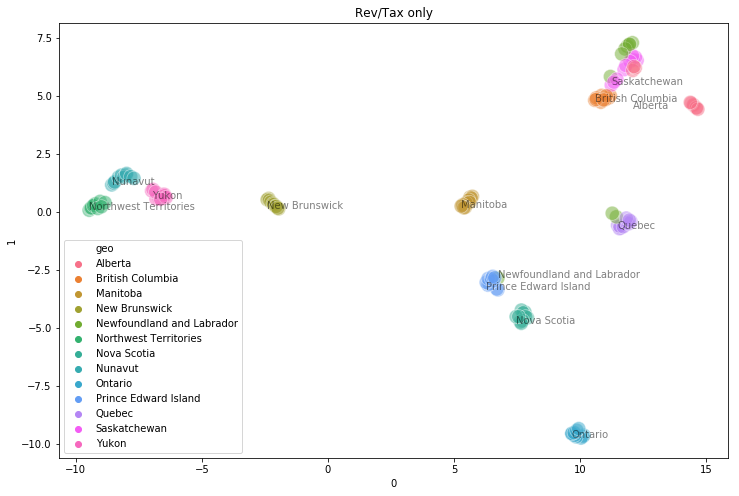

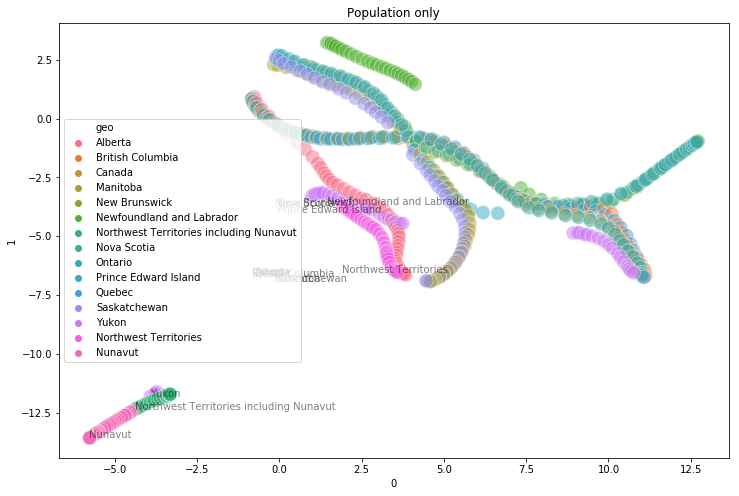

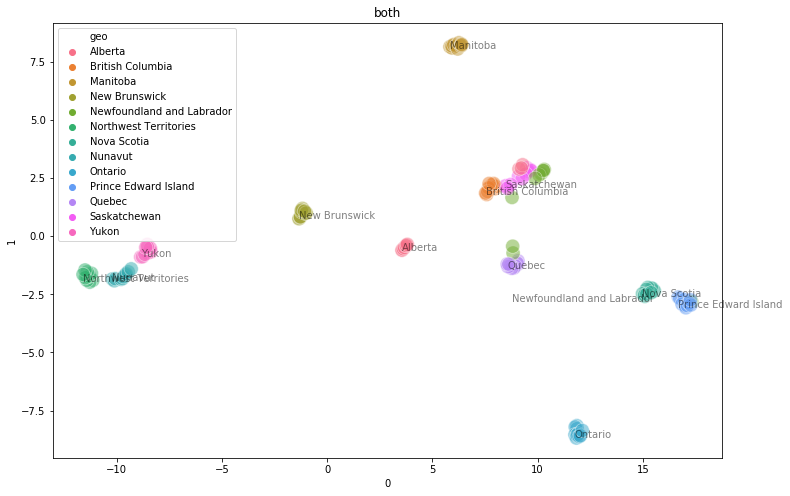

In [70]:


def doplot(dd):
    data = dd
#     data = sp.QuantileTransformer(copy=True, ignore_implicit_zeros=False, n_quantiles=1000,
#           output_distribution='uniform', random_state=None,
#           subsample=100000).fit_transform(dd)

    model = umap.UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
       learning_rate=0.1, local_connectivity=1.0, metric='correlation',
       metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=1000,
       n_neighbors=15, negative_sample_rate=5, random_state=None,
       repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
       target_metric='categorical', target_metric_kwds=None,
       target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
       transform_seed=42, verbose=False).fit(data)

    e = pd.DataFrame(model.embedding_, index=dd.index).reset_index()

    figure(figsize=(12, 8))
    sns.scatterplot(x=0, y=1, hue='geo', data=e, s=200, alpha=0.5)

    for k, x in e.groupby('geo')[[0, 1]].min().iterrows():
        text(x[0], x[1], k, alpha=0.5)
        
        
doplot(d)
title('Rev/Tax only')
doplot(p)
title('Population only')
doplot(dd)
title('both')

In [83]:
comp_cols = [x for x in d.columns if 'compensation' in x.lower()]
comp_cols

["Contributions to workers' compensation boards",
 'Compensation of employees',
 "Workers' compensation benefits",
 'Memorandum items, capitalized research and development compensation of employees']

In [85]:
rev_cols = [x for x in d.columns if 'rev' in x.lower()]
rev_cols

['Revenue',
 'Grants, revenue',
 'Other revenue',
 'Interest revenue',
 'Miscellaneous revenue']

# Charts

In [77]:
import seaborn as sns
s = df.set_index(['ref_date', 'geo', 'entry']).value.dropna()
assert s.index.is_unique
d = s.unstack(['entry']).fillna(0)

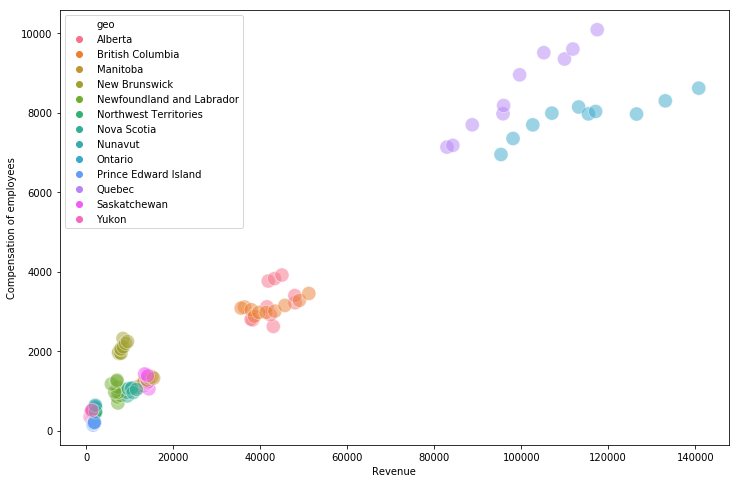

In [78]:
%matplotlib inline
dd = d.reset_index()
dd['% Revenue to Employees'] = dd['Compensation of employees'] / dd['Revenue']
from pylab import *

figure(figsize=(12, 8))
ax = sns.scatterplot(x="Revenue", y="Compensation of employees", hue="geo", data=dd, s=200, alpha=0.5)

In [80]:
dd.head()

entry,ref_date,geo,Gross operating balance,Net operating balance,Revenue,Taxes,"Taxes on income, profits and capital gains","Taxes on income, profits and capital gains payable by individuals","Taxes on income, profits and capital gains payable by corporations and other enterprises","Taxes on income, profits and capital gains payable by nonresidents",Taxes on payroll and workforce,Taxes on property,Taxes on goods and services,General taxes on goods and services,Excises,Liquor taxes,Tobacco taxes,Gasoline and motive fuel taxes,Other excise taxes,Profits of fiscal monopolies,Remitted liquor profits,Remitted profits on games of chance and other,Taxes on specific services,Taxes on use of goods and on permission to use goods or perform activities,Motor vehicle taxes,Other taxes on use of goods and on permission to use goods or perform activities,Other taxes on goods and services,Other taxes,Social contributions,Social security contributions,Contributions to workers' compensation boards,Other social security contributions,Other social contributions,"Grants, revenue",Grants from foreign governments and international governmental organizations,Grants from general government units,Other revenue,Property income,Interest revenue,Dividends,Rent,Oil and gas royalties,Forestry royalties,Mineral royalties,Water power royalties,Other rent and property income,Sales of goods and services,Administrative fees,Other sales of goods and services,"Fines, penalties and forfeits",...,"Memorandum items, Quebec abatement","Memorandum items, capitalized research and development costs","Memorandum items, capitalized research and development compensation of employees","Memorandum items, capitalized research and development use of goods and services","Memorandum items, tangible assets amortization expense according to public sector accounts",Net worth,Nonfinancial assets,Net financial worth,Financial assets,"Currency and deposits, assets","Debt securities, assets","Treasury bills, assets","Finance and other short-term paper, assets","Bonds, assets","Loans, assets","Loans and advances, assets","Mortgages, assets","Equity and investment fund shares, assets",Marketable shares,Non-marketable shares and other equity,Investment fund shares,"Insurance and pension, assets",Other accounts receivable,"Trade credits and advances, receivable",Other receivable,"Monetary gold and special drawing rights (SDR), assets",Liabilities,"Currency and deposits, liabilities","Debt securities, liabilities","Treasury bills, liabilities","Finance and other short-term paper, liabilities",Saving bonds,"Bonds, liabilities","Loans, liabilities",Bank overdrafts,"Loans and advances, liabilities","Mortgages, liabilities","Equity, liabilities","Insurance, pension and standardized guarantee schemes, liabilities","Pensions plans, liabilities","Insurance and standardized guarantee schemes, liabilities",Other accounts payable,"Trade credits and advances, payable",Other payable,"Monetary gold and special drawing rights (SDR), liabilities","Memorandum items, nonfinancial assets according to public sector accounts","Memorandum items, liabilities at nominal value","Memorandum items, employee future benefits","Memorandum items, environmental liabilities",% Revenue to Employees
0,2008,Alberta,4696.0,3555.0,43000.0,20509.0,13799.0,9567.0,4232.0,0.0,0.0,1486.0,5224.0,0.0,1615.0,0.0,829.0,719.0,68.0,2189.0,678.0,1512.0,406.0,752.0,336.0,416.0,261.0,0.0,1034.0,1034.0,994.0,40.0,0.0,4451.0,0.0,4451.0,17006.0,14334.0,1343.0,82.0,12910.0,11863.0,36.0,36.0,4.0,971.0,2483.0,221.0,2262.0,88.0,...,0.0,73.0,39.0,34.0,690.0,124034.0,90968.0,33066.0,67889.0,972.0,42175.0,2472.0,9792.0,29911.0,2890.0,2886.0,4.0,16939.0,9625.0,5288.0,2026.0,0.0,4913.0,302.0,4611.0,0.0,34823.0,0.0,9574.0,0.0,31.0,0.0,9543.0,1105.0,0.0,1104.0,1.0,0.0,10108.0,10105.0,2.0,14037.0,336.0,13701.0,0.0,17139.0,34107.0,430.0,110.0,0.060930
1,2008,British Columbia,-324.0,-1533.0,36396.0,23328.0,10406.0,7827.0,2579.0,0.0,0.0,2697.0,10225.0,5011.0,

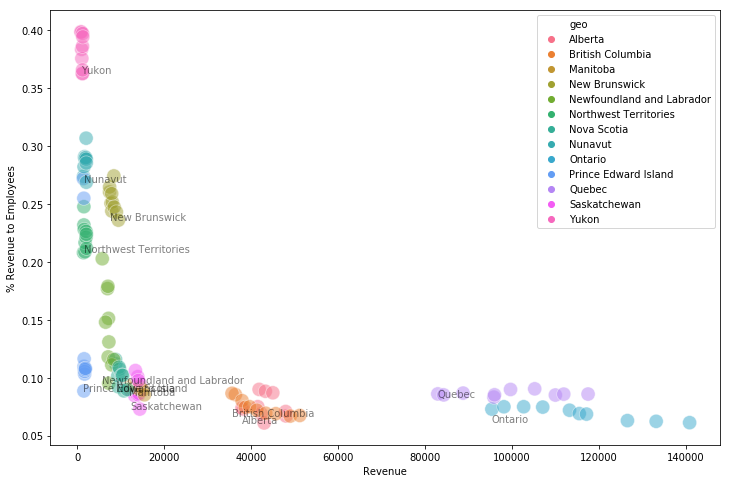

In [81]:
figure(figsize=(12, 8))
ax = sns.scatterplot(x="Revenue", y="% Revenue to Employees", hue="geo", data=dd, s=200, alpha=0.5)
for k, x in dd.groupby('geo')[["Revenue", "% Revenue to Employees"]].min().iterrows():
    text(x[0], x[1], k, alpha=0.5)
# ax.set_xscale('log')

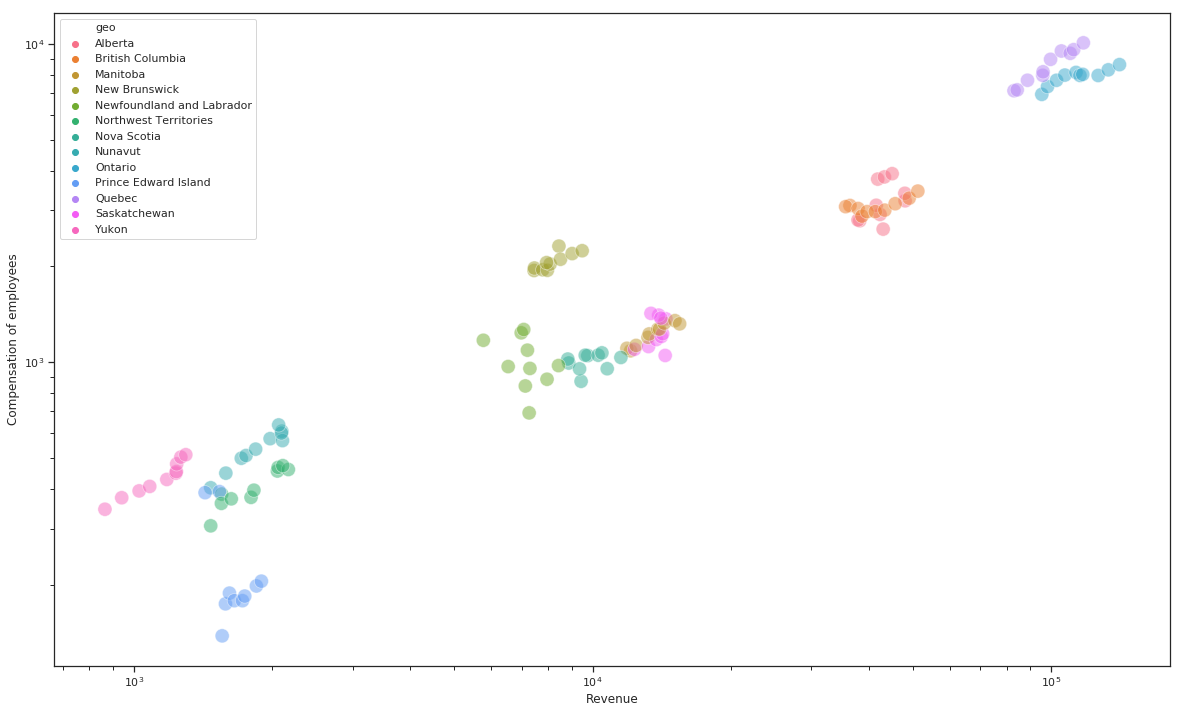

In [158]:
%matplotlib inline
dd = d.reset_index()
from pylab import *
figure(figsize=(20, 12))
ax = sns.scatterplot(x="Revenue", y="Compensation of employees", hue="geo", data=dd, s=200, alpha=0.5)
ax.set_xscale('log')
ax.set_yscale('log')

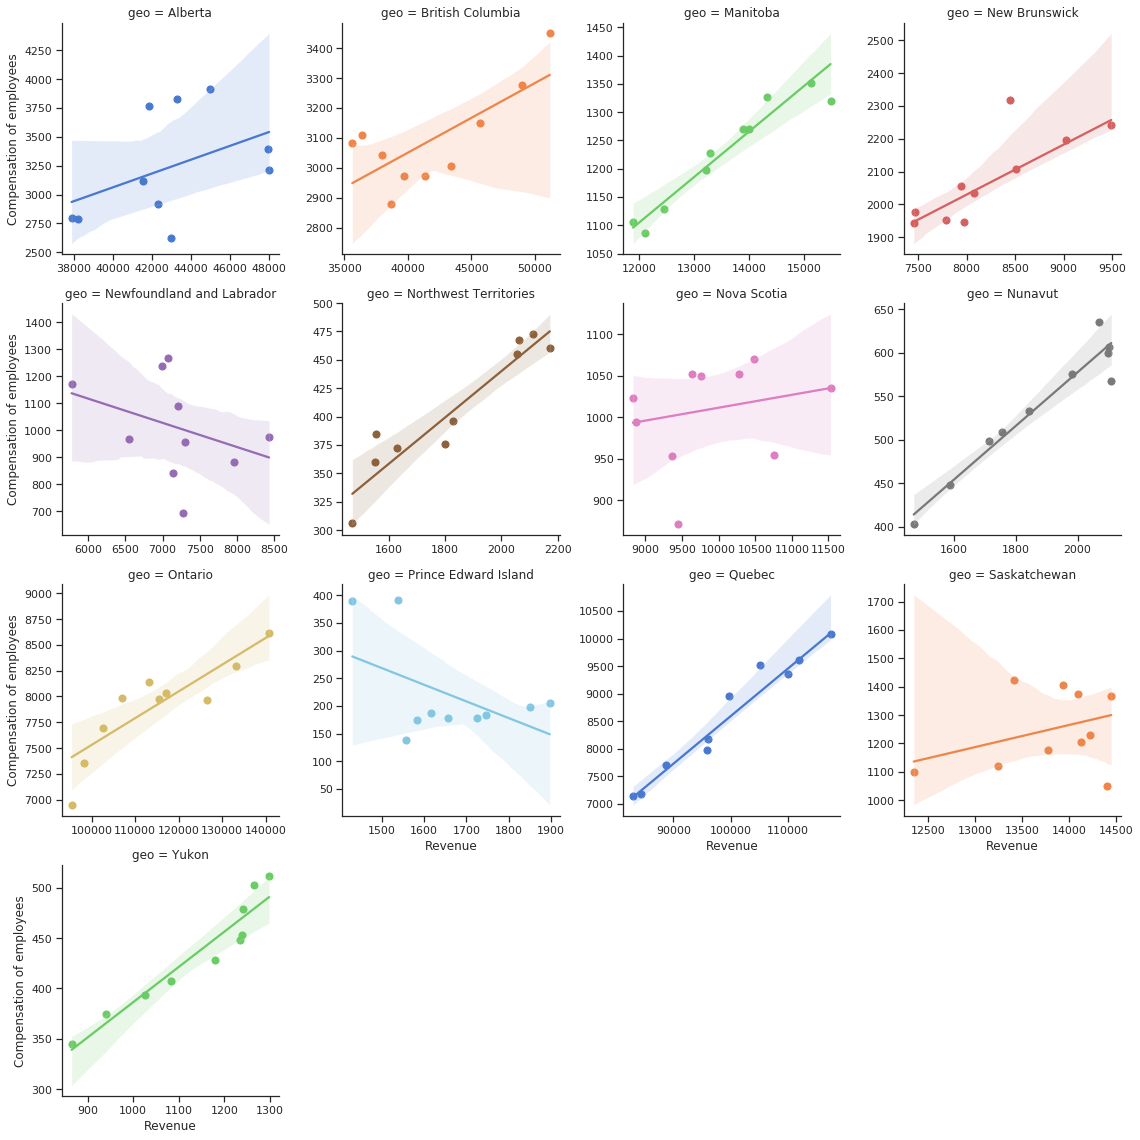

In [149]:
ax = sns.lmplot(x="Revenue", y="Compensation of employees", hue="geo",
                col="geo", data=dd, col_wrap=4, truncate=True, sharex=False, sharey=False,
                palette="muted", height=4,
                scatter_kws={"s": 50, "alpha": 1}, robust=True,
                order=1)